### Heat equation
Custom 3D form:

\begin{equation*}
\begin{cases} 
\frac{\partial u}{\partial t} = a^2 \frac{\partial^2 u}{\partial x^2} & x \in (0,L), \; t > 0, \; a \in [0,1] \\
u(0,t,a) = u(L,t,a) = 0 & t > 0, \; a \in [0,1]\\
u(x,0,a) = h(x) & x \in (0,L), \; a \in [0,1] \\
\end{cases}
\end{equation*}

with the particular case where $h(x) = 2\sin(\alpha \frac{\pi}{L}x)$ and $L=\pi$. Note that $\alpha$ is a constant we can tune to adjust the frequency of the desired solution. 
The solution of the three dimensional Heat equation for this particular case is given by: 
\begin{equation*}
u_{exact}(x,t,a) = 2\sin(\alpha \cdot x) \cdot e^{-a^2 t}
\end{equation*}

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

### DNN

In [2]:
import torch
from torch import nn 
from collections import OrderedDict
torch.manual_seed(0)

class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(len(layers) - 2): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (len(layers) - 2), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)

        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out
    

### PINN

In [3]:
import torch.optim as optim

class PINN():
    def __init__(self, layers, x, t, a, alpha, N_sup=0, tol=1e-5, hs=50, verbose=True): 
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.verbose = verbose
        if self.verbose:
            print(f"device used: {self.device}")
            print(f"x shape: {x.shape}")
            print(f"t shape: {t.shape}")
            print(f"a shape: {a.shape}")
        
        self.net = DNN(layers).to(self.device)
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                
        #set alpha parameter
        self.alpha = alpha
        #set N_sup
        self.N_sup = N_sup
        # generate collocation points (first N_col points from the randomly sampled vectors)
        N_col = 40 # number of collocation points
        
        self.col_x_tensor = torch.repeat_interleave(torch.tensor(x[:N_col,:,:]).squeeze(), N_col).unsqueeze(-1).repeat(N_col,1).float().to(self.device)
        self.col_t_tensor = torch.repeat_interleave(torch.tensor(t[:,:N_col,:]).squeeze(), N_col**2).unsqueeze(-1).float().to(self.device)
        self.col_a_tensor = torch.tensor(a[:,:,:N_col]).squeeze().unsqueeze(-1).repeat(N_col**2,1).float().to(self.device)
        self.col_x_tensor.requires_grad_()
        self.col_t_tensor.requires_grad_()
        self.col_a_tensor.requires_grad_()
        
        # generate support points (last N_sup points from the randomly sampled vectors)
        if(N_sup != 0):
            self.sup_x_tensor = torch.repeat_interleave(torch.tensor(x[-N_sup:,:,:]).squeeze(), N_sup).unsqueeze(-1).repeat(N_sup,1).float().to(self.device)
            self.sup_t_tensor = torch.repeat_interleave(torch.tensor(t[:,-N_sup:,:]).squeeze(), N_sup**2).unsqueeze(-1).float().to(self.device)
            self.sup_a_tensor = torch.tensor(a[:,:,-N_sup:]).squeeze().unsqueeze(-1).repeat(N_sup**2,1).float().to(self.device)
            self.sup_x_tensor.requires_grad_()
            self.sup_t_tensor.requires_grad_()
            self.sup_a_tensor.requires_grad_()
        
        # constants for the correct generation of boundary conditions
        N_x = x.shape[0]
        N_t = t.shape[1]
        N_a = a.shape[2]
        
        # 1. x=0 and x=pi boundary points
        # initial condition points(x=0)
        self.x0_x_tensor = torch.zeros([N_x**2,1]).to(self.device)
        self.x0_t_tensor = torch.repeat_interleave(torch.tensor(t),N_t).unsqueeze(-1).float().to(self.device)
        self.x0_a_tensor = torch.tensor(a).squeeze().unsqueeze(-1).repeat(N_a,1).float().to(self.device)
        self.x0_x_tensor.requires_grad_()
        self.x0_t_tensor.requires_grad_()
        self.x0_a_tensor.requires_grad_()  
        
        # final condition points (x=pi)
        self.xpi_x_tensor = math.pi*torch.ones([N_x**2,1]).to(self.device)
        self.xpi_t_tensor = torch.repeat_interleave(torch.tensor(t),N_t).unsqueeze(-1).float().to(self.device)
        self.xpi_a_tensor = torch.tensor(a).squeeze().unsqueeze(-1).repeat(N_a,1).float().to(self.device)    
        self.xpi_x_tensor.requires_grad_()
        self.xpi_t_tensor.requires_grad_()
        self.xpi_a_tensor.requires_grad_() 

        # 2. t=0 initial condition points
        self.t0_x_tensor = torch.repeat_interleave(torch.tensor(x),N_x).unsqueeze(-1).float().to(self.device)
        self.t0_t_tensor = torch.zeros([N_t**2,1]).to(self.device)
        self.t0_a_tensor = torch.tensor(a).squeeze().unsqueeze(-1).repeat(N_a,1).float().to(self.device)
        self.t0_x_tensor.requires_grad_()
        self.t0_t_tensor.requires_grad_()
        self.t0_a_tensor.requires_grad_()
        
        self.optimizer = torch.optim.LBFGS(
            self.net.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=hs,
            tolerance_grad=tol, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"    
        )

        self.iter = 1
        
    def net_u(self, x, t, a): #get u(x, t, a) for a pair (x, t, a); a forward pass through the PINN
        u = self.net(torch.cat([x, t, a], dim=1))
        return u
    
    def net_f(self, x, t, a): #get f = u_t - a^2*u_xx; the true u(x, t, a) makes f = 0
        u = self.net_u(x, t, a)
        u_t = torch.autograd.grad( #first partial derivative with respect to t
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True,
        )[0]
        u_x = torch.autograd.grad( #first partial derivative with respect to x
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad( #second partial derivative with respect to x
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        f = u_t - (a**2)*u_xx   #the computed PDE, we want to be a close as possible to 0
        
        return f

    def loss_func(self):
        self.optimizer.zero_grad()       
        # x=0 and x=pi boundary points
        u_pred_x0 = self.net_u(self.x0_x_tensor, self.x0_t_tensor, self.x0_a_tensor) # all the ic/bc pairs were fed through the PINN
        u_pred_xpi = self.net_u(self.xpi_x_tensor, self.xpi_t_tensor, self.xpi_a_tensor)
        
        # t=0 boundary points
        u_pred_t0 = self.net_u(self.t0_x_tensor, self.t0_t_tensor, self.t0_a_tensor)
        
        # evalutation of main equation using collocation points
        f_pred = self.net_f(self.col_x_tensor, self.col_t_tensor, self.col_a_tensor) # all the collocations points were fed through the PINN
        
        if(self.N_sup!=0):
            # predictions over support points
            u_pred_sup = self.net_u(self.sup_x_tensor, self.sup_t_tensor, self.sup_a_tensor)
        
        #loss for ic/bc 
        loss_u = torch.mean(u_pred_x0 ** 2) #MSE loss on the ic/bc pairs, MSE loss on trainset, classic NN
        loss_u += torch.mean(u_pred_xpi ** 2)
        # ic on t
        loss_u += torch.mean((2*torch.sin(self.alpha*self.t0_x_tensor) - u_pred_t0) ** 2)
        
        # main equation loss
        loss_f = torch.mean(f_pred ** 2) #MSE loss on the collocations pairs, regularization term

        if(self.N_sup!=0):
        # loss of support points against true solution
            loss_sup = torch.mean((2*torch.sin(self.alpha*self.sup_x_tensor)*torch.exp(-(self.sup_a_tensor*self.sup_a_tensor)*self.sup_t_tensor) - u_pred_sup) ** 2)
            loss = loss_u + loss_f + loss_sup #classic loss + regularization loss (enforce the PDE structure) +support loss (improve results)=> PINN loss
        else : loss = loss_u + loss_f  #classic loss + regularization loss (enforce the PDE structure) => PINN loss
        
        
        loss.backward() #backpropagation
        
        self.iter += 1
        if self.verbose:
            if self.iter % 1000 == 0:
                print(
                    'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
                )
        return loss
    
    def train(self):
        self.net.train()
        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, x, t, a):
        x_tensor = torch.tensor(x, requires_grad=True).float().to(self.device) #get x as tensor
        t_tensor = torch.tensor(t, requires_grad=True).float().to(self.device) #get t as tensor
        a_tensor = torch.tensor(a, requires_grad=True).float().to(self.device) #get a as tensor
        self.net.eval()

        u = self.net_u(x_tensor, t_tensor, a_tensor) 
        f = self.net_f(x_tensor, t_tensor, a_tensor)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

### Data generation

In [4]:
from scipy.stats import qmc

N_true = 100 #Number of points in the true solution
x_true = math.pi*np.linspace(0,1,N_true)
t_true = np.linspace(0,1,N_true)
a_true = np.linspace(0,1,N_true)

# exact solution
def f_exact(x,t,a, alpha=2):
    return 2*np.sin(alpha*x)*np.exp(-(a**2)*t)

x_exact = np.tile(x_true,N_true).repeat(N_true)
t_exact = np.repeat(t_true,N_true**2)
a_exact = np.tile(a_true,N_true**2)
ex = f_exact(x_exact, t_exact, a_exact).reshape(-1,1)

sampler = qmc.LatinHypercube(d=3)
sample = sampler.random(n=100)
x = sample[:,0].reshape(-1, 1, 1)
t = sample[:,1].reshape(1, -1, 1)
a = sample[:,2].reshape(1, 1, -1)

### Create and train

In [5]:
nb_nodes = 20
nb_hidden_layers = 7
layers = np.hstack([np.array([3]),np.full(nb_hidden_layers, nb_nodes),np.array([1])])

model = PINN(layers, x, t, a, alpha=2)

model.train()

device used: cuda:0
x shape: (100, 1, 1)
t shape: (1, 100, 1)
a shape: (1, 1, 100)
Iter 1000, Loss: 4.21446e-05, Loss_u: 1.18742e-05, Loss_f: 3.02704e-05
Iter 2000, Loss: 8.50700e-06, Loss_u: 3.61627e-06, Loss_f: 4.89074e-06
Iter 3000, Loss: 2.94479e-06, Loss_u: 9.87221e-07, Loss_f: 1.95757e-06


### Evaluate

In [6]:
def l2_norm(pred, true):
    return np.linalg.norm(true - pred,2)/np.linalg.norm(true, 2)

def mse(pred, true):
    return ((pred - true)**2).mean(axis=0).item()

u_pred, f_pred = model.predict(x_exact.reshape(-1,1), t_exact.reshape(-1,1), a_exact.reshape(-1,1))

l2_u = l2_norm(u_pred, ex)  
print('L2 Error u: %e' % (l2_norm(u_pred, ex))) 

mse_u = mse(u_pred, ex)
mse_f = mse(f_pred, np.zeros(f_pred.shape))

print(f"MSE Error u: {mse_u}") 
print(f"MSE Error f: {mse_f}") 

L2 Error u: 7.318525e-01
MSE Error u: 0.81004566123298
MSE Error f: 12.934025761733158


In [7]:
# 9 evalutations of f_exact for different fixed values of a and t:
true_lst = [] # list of 9 evaluations of f_exact
pred_lst = [] # list of 9 evaluations of PINN
x_true = x_true.reshape(-1,1)   # evaluate f over fine grid of x_true
x_len = x_true.shape[0]
a_lst = [0.25,0.5,0.75]
t_lst = [0.25,0.5,0.75]
for t_tmp in t_lst:
    for a_tmp in a_lst:
        t_vec = t_tmp*np.ones((x_len, 1))
        a_vec = a_tmp*np.ones((x_len, 1)) 
        # evaluate using exaxt solution
        true_lst.append(f_exact(x_true,t_vec,a_vec)) 

        # evaluate same points using PINN
        u_pred, _ = model.predict(x_true.reshape(-1,1), t_vec.reshape(-1,1), a_vec.reshape(-1,1))
        pred_lst.append(u_pred)

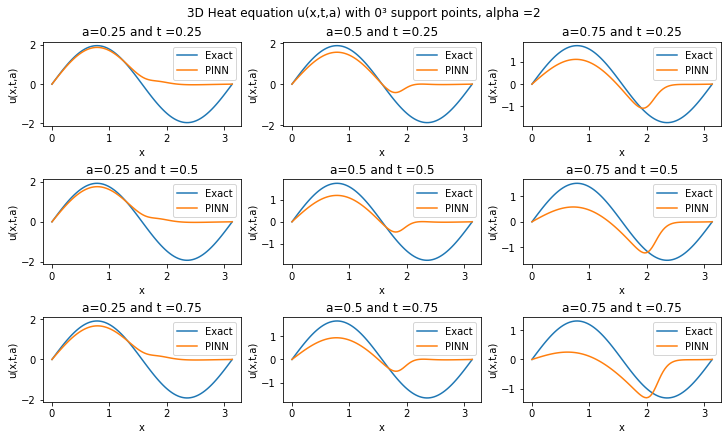

In [8]:
#Create plot
fig, axs = plt.subplots(3, 3, figsize=(10, 6), sharex=False, constrained_layout = True)
for i in range(3):    #iterate over t
    for j in range(3):    #iterate over a
        axs[i,j].set_title(f'a={0.25*(j+1)} and t ={0.25*(i+1)}')
        axs[i,j].plot(x_true, true_lst[3*i+j])
        axs[i,j].plot(x_true, pred_lst[3*i+j])
        axs[i,j].legend(['Exact', 'PINN'])
        axs[i,j].set_xlabel('x')
        axs[i,j].set_ylabel('u(x,t,a)')
plt.suptitle(f'3D Heat equation u(x,t,a) with {model.N_sup}\u00b3 support points, alpha ={model.alpha}')
fig.show;
plt.savefig(fname=f'3D Heat equation u(x,t,a) with LBFGS {model.N_sup}^3 support points, alpha ={model.alpha} ')

### Comparison with different number of Support points, and 2 frequencies, for report

device used: cuda:0
x shape: (100, 1, 1)
t shape: (1, 100, 1)
a shape: (1, 1, 100)
Iter 1000, Loss: 1.68299e-04, Loss_u: 4.50533e-05, Loss_f: 1.23245e-04
Iter 2000, Loss: 4.76441e-05, Loss_u: 8.54653e-06, Loss_f: 3.90976e-05
Iter 3000, Loss: 3.00626e-05, Loss_u: 5.82234e-06, Loss_f: 2.42403e-05
Iter 4000, Loss: 2.07525e-05, Loss_u: 4.70573e-06, Loss_f: 1.60468e-05
Iter 5000, Loss: 1.48824e-05, Loss_u: 3.25823e-06, Loss_f: 1.16242e-05
Iter 6000, Loss: 1.15477e-05, Loss_u: 3.19141e-06, Loss_f: 8.35631e-06
L2 Error u: 1.125978e-03 with alpha = 1  and N_sup= 0
device used: cuda:0
x shape: (100, 1, 1)
t shape: (1, 100, 1)
a shape: (1, 1, 100)
Iter 1000, Loss: 5.85791e-05, Loss_u: 1.36444e-05, Loss_f: 4.10066e-05
Iter 2000, Loss: 1.78760e-05, Loss_u: 3.10306e-06, Loss_f: 1.33807e-05
Iter 3000, Loss: 8.05933e-06, Loss_u: 2.05243e-06, Loss_f: 5.61475e-06
Iter 4000, Loss: 4.39480e-06, Loss_u: 1.19790e-06, Loss_f: 3.03243e-06
L2 Error u: 5.598090e-04 with alpha = 1  and N_sup= 10
device used: cu

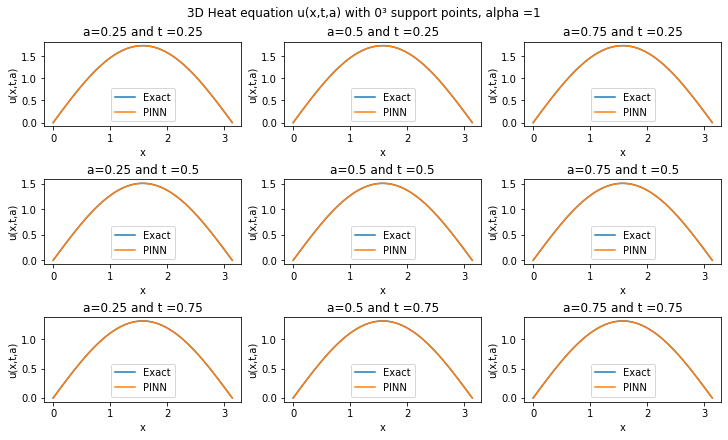

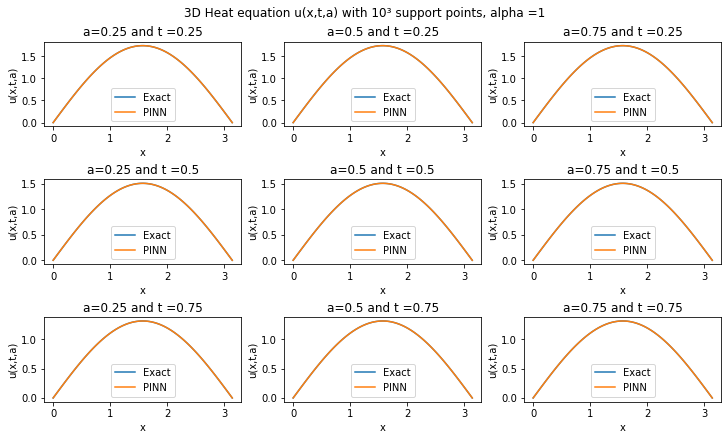

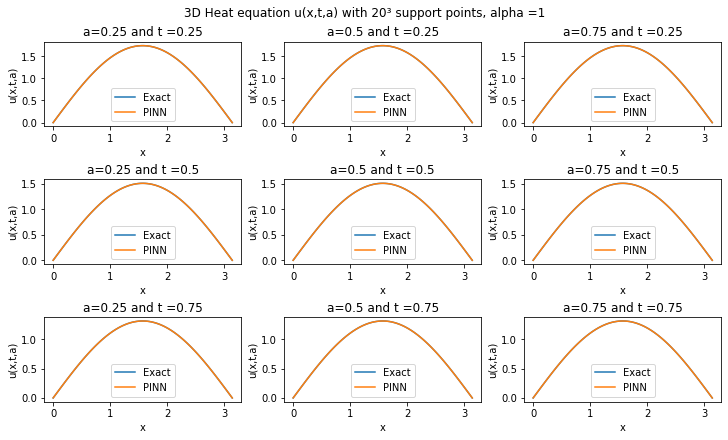

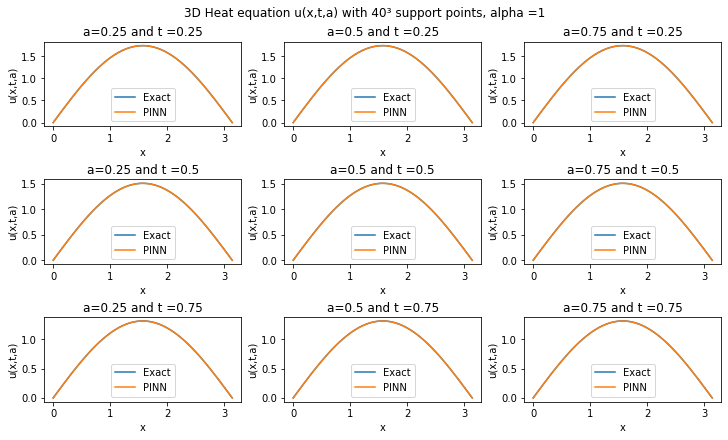

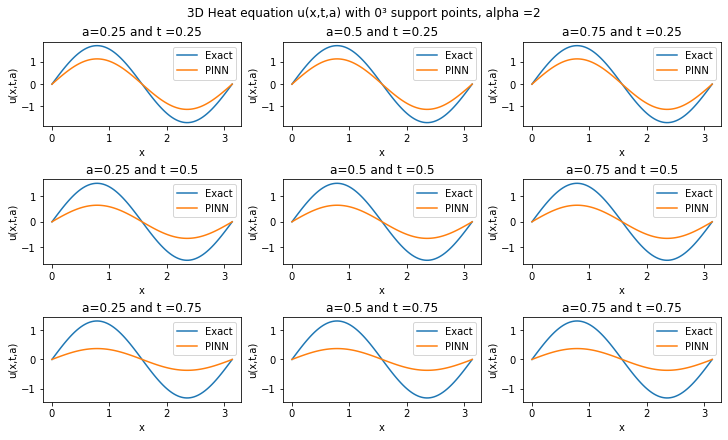

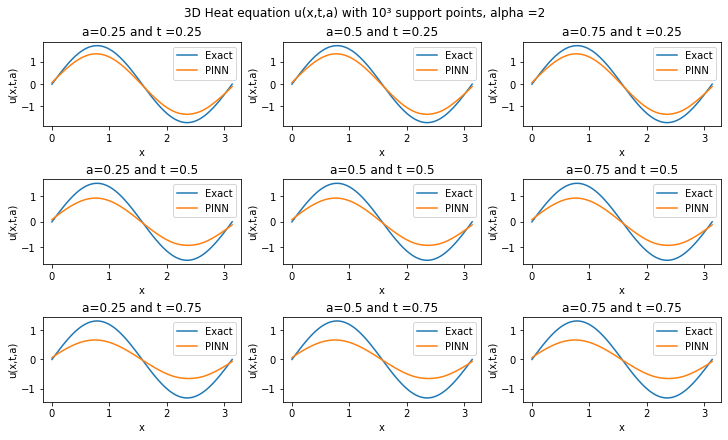

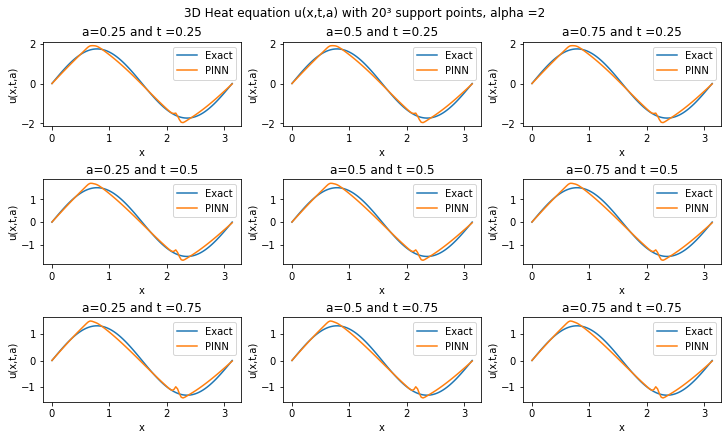

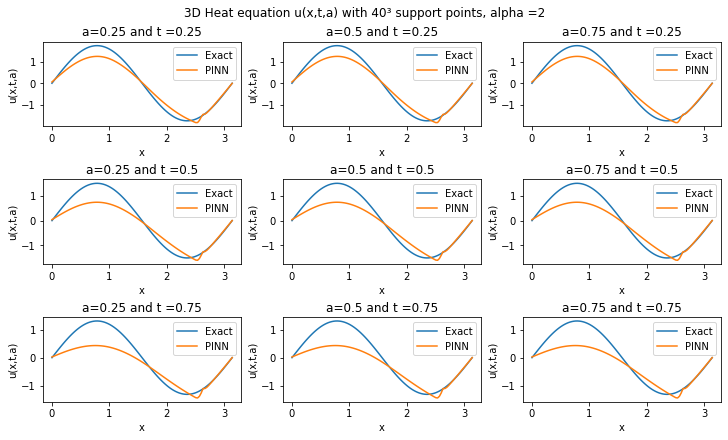

In [9]:
nb_nodes = 20
nb_hidden_layers = 7
layers = np.hstack([np.array([3]),np.full(nb_hidden_layers, nb_nodes),np.array([1])])
for alpha in range(1,3):
    #Define exact solution with current alpha
    N_true = 100 #Number of points in the true solution
    x_true = math.pi*np.linspace(0,1,N_true)
    t_true = np.linspace(0,1,N_true)
    a_true = np.linspace(0,1,N_true)
    x_exact = np.tile(x_true,N_true).repeat(N_true)
    t_exact = np.repeat(t_true,N_true**2)
    a_exact = np.tile(a_true,N_true**2)
    ex = f_exact(x_exact, t_exact, a_exact, alpha).reshape(-1,1)
    for sup in np.array([0,10,20,40]):
        # Number of points in each dimensions
        N_x = 100
        N_t = 100
        N_a = 100
        # generate grid for collocation and boundary points
        x = math.pi * np.random.rand(N_x,1,1)
        t = np.random.rand(1,N_t,1)
        a = np.random.rand(1,1,N_a)
        model = PINN(layers, x, t, a, alpha=alpha, N_sup=sup)
        model.train()
        u_pred, _ = model.predict(x_exact.reshape(-1,1), t_exact.reshape(-1,1), a_exact.reshape(-1,1))
        l2_u = l2_norm(u_pred, ex)  
        print('L2 Error u: %e' % (l2_norm(u_pred, ex)), f'with alpha = {alpha}', f' and N_sup= {sup}') 
        # 9 evalutations of f_exact for different fixed values of a and t:
        true_lst = [] # list of 9 evaluations of f_exact
        pred_lst = [] # list of 9 evaluations of PINN
        x_true = x_true.reshape(-1,1)   # evaluate f over fine grid of x_true
        x_len = x_true.shape[0]
        a_lst = [0.25,0.5,0.75]
        t_lst = [0.25,0.5,0.75]
        for t_tmp in t_lst:
            for a_s in a_lst:
                t_vec = t_tmp*np.ones((x_len, 1))
                a_vec = a_tmp*np.ones((x_len, 1)) 
                # evaluate using exaxt solution
                true_lst.append(f_exact(x_true,t_vec,a_vec,alpha)) 

                # evaluate same points using PINN
                u_pred, _ = model.predict(x_true.reshape(-1,1), t_vec.reshape(-1,1), a_vec.reshape(-1,1))
                pred_lst.append(u_pred)
        #Create plot
        fig, axs = plt.subplots(3, 3, figsize=(10, 6), sharex=False, constrained_layout = True)
        for i in range(3):    #iterate over t
            for j in range(3):    #iterate over a
                axs[i,j].set_title(f'a={0.25*(j+1)} and t ={0.25*(i+1)}')
                axs[i,j].plot(x_true, true_lst[3*i+j])
                axs[i,j].plot(x_true, pred_lst[3*i+j])
                axs[i,j].legend(['Exact', 'PINN'])
                axs[i,j].set_xlabel('x')
                axs[i,j].set_ylabel('u(x,t,a)')
        plt.suptitle(f'3D Heat equation u(x,t,a) with {model.N_sup}\u00b3 support points, alpha ={model.alpha}')
        fig.show;
        plt.savefig(fname=f'3D Heat equation u(x,t,a) with LBFGS {model.N_sup}^3 support points, alpha ={model.alpha} ')